In [64]:
import os
import sys
import glob
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xray
import random
import itertools
import urllib
import json
import importlib as imp

from IPython import display

sys.path.append('/nuwa_cluster/home/jackyu/climatools/')
import climatools.dates as climadates
import climatools.viz as climaviz
import climatools.misc as climamisc
import climatools.muths as climaths
import climatools.units as climaunits
import climatools.geocoords as climageocoords

#from IPython.lib.deepreload import reload as dreload
imp.reload(climadates)
imp.reload(climaviz)
imp.reload(climamisc)
imp.reload(climaths)
imp.reload(climaunits)

matplotlib.rcParams.update({'font.size': 13, 
                            'xtick.direction': 'out',
                            'ytick.direction': 'out'})

# MPACE

# Cases and netCDF file paths

2 cases considered here are:

* All McICA --- RRTMG used for both longwave and shortwave
* no SW McICA --- RRTMG used for both longwave and shortwave, with shortwave McICA replaced with CLIRAD's max-random


In [4]:
iopname = 'mpace'

# Each case here refers to a model, or a model configuration, and is assigned the path to its output data.
def get_cases():
    '''
    Returns a dictionary where the keys are cases, such
    as a name for a SCAM run, and the values are the paths
    to the output data from the run
    '''
    return {'All McICA': '../examples/MPACE/cam5_3hrly_LWrrtmg_SWrrtmg/camrun.cam.h0.2004-10-05-07171.nc',
            'SW no McICA': '../examples/MPACE/cam5_3hrly_LWrrtmg_SWrrtmg_SWnoMcICA/camrun.cam.h0.2004-10-05-07171.nc'}

def linestyles_by_case():
    return {'All McICA': {'colour': 'g', 'linestyle': '--'},
            'SW no McICA': {'colour': 'g', 'linestyle': '-'}}


In [5]:
def get_cases_difference():
    return [('SW no McICA', 'All McICA'),]

In [6]:
############### Coordinate conversion functions ################
################################################################
# *lev* is converted from hybrid levels to mbar.    
# *time* is converted from days since start to datetime.datetime objects


def convert_pressure_time_units(cases):
    '''
    Convert pressure and time units to mbar and datetime objects.
    This assumes all datasets have the same pressure and time
    coordinates.  This conversion is done early using fields such as
    hyam, which will not be needed later.
    '''
    with xray.open_dataset(cases[random.choice(list(cases.keys()))], 
                           decode_times = False) as ds:
        lev = climaunits.hybrid2mbar(ds, level_type = 'lev')
        ilev = climaunits.hybrid2mbar(ds, level_type = 'ilev')
        datetimes = climadates.time2datetimes(ds)
        datetimes = [climadates.\
                     UTCtime_to_localtime(datetime, 
                                          lon = climageocoords.\
                                          positivise_longitude(ds['lon'].values[0])) \
                     for datetime in datetimes]
    return ilev, lev, datetimes

In [7]:
cases = get_cases()
ilev, lev, datetimes = convert_pressure_time_units(cases)

In [8]:
################## Variables of dimensions (time, lev, lon, lat) ########################
################################################################################

In [54]:
### for pre-processing



def get_d3interests():
    '''List all interested fields here.  
    These have to be of dimensions (time, lev, lon, lat)'''
    d3interests = ['CLOUD', 'QRL', 'QRS', 'Q',
                   'CLDICE', 'CLDLIQ', 
                   'AQSNOW', 'AREI', 'AREL',
                  'AWNC', 'AWNI', 
                   'DCQ', 'DTCOND', 
                   'ICIMR', 'ICWMR', 
                   'NUMLIQ', 'NUMICE', 'T', 'RELHUM',
                  'FUL', 'FDL', 'FULC', 'FDLC',
                  'FUS', 'FDS', 'FUSC', 'FDSC',
                  'TOT_CLD_VISTAU',]
    return sorted(d3interests)


def gather_interests_from_cases(cases, interests):
    '''
    Creates a dictionary with keys being the cases.
    For each case is an Xray Dataset containing the interested fields
    '''
    datasets = {} 

    for case, filepath in cases.items():
        with xray.open_dataset(filepath, decode_times = False) as ds:
            datasets[case] = ds[interests].copy(deep = True)
            datasets[case].attrs['case_name'] = case
    return datasets


def convert_units(datasets, ilev, lev, datetimes):
    '''
    Convert units for certain fields for all cases in DATASETS.
    INPUT:
    ilev --- level(interface) pressure in mbar
    lev  --- layer(level) pressure in mbar
    datetimes --- time in pandas DatetimeIndex objects
    '''
    for name, ds in datasets.items():
        ds.coords['ilev'] = ('ilev', ilev, {'units': 'mbar'})
        ds.coords['lev'] = ('lev', lev, {'units': 'mbar'})
        ds.coords['time'] = ('time', datetimes, {'units': 'datetime'})
        
        for k in ['TOT_CLD_VISTAU',]:
            if k in ds:
                pass #ds[k].values[ds[k].isnull().values] = - 0.
        
        for k in ['FUS', 'FDS']:
            if k in ds:
                ds[k] *= 1e3
    
        for k in ['QRL', 'QRS', 'DTCOND']:
            if k in ds:
                ds[k] *= 86400
                ds[k].attrs['units'] = 'K/day'
        
        for k in ['Q', ]:
            if k in ds:
                ds[k] *= 1e3
                ds[k].attrs['units'] = 'g/kg'
        
        for k in ['CLDICE', 'CLDLIQ', 'AQSNOW']:
            if k in ds:
                ds[k] *= 1e6
                ds[k].attrs['units'] = 'mg/kg'
                
    return datasets


def take_difference_between_cases(datasets):
    '''
    Take the difference between all cases for every field
    and return in a similar dictionary
    '''
    diff_strs = get_cases_difference()
    
    return {x + ' - ' + y: datasets[x] - datasets[y] 
            for x, y in diff_strs}


def passon_attrs_casename(datasets, diff_datasets):
    '''
    Create an attribute for each case.
    Copy over attributes to the differences.
    This is not nice, might be good to get rid of 
    the dependency on this.
    '''
    interests = get_d3interests()
    
    for ds_name, ds in diff_datasets.items():
        ds.attrs['case_name'] = ds_name
        for interest in interests:
            ds[interest].attrs = dict(
                datasets[random.choice(list(datasets.keys()))][interest].attrs)
            ds[interest].attrs['case_name'] = ds_name
        
    for ds_name, ds in datasets.items():
        for interest in interests:
            ds[interest].attrs['case_name'] = ds_name
            
    return datasets, diff_datasets


def prep_data(cases, ilev, lev, datetimes):
    '''
    Preprocess data for plotting. 
    pressure and datetimes need to be provided for unit conversion.
    INPUT:
    ilev --- level(interface) pressure [mbar]
    lev --- layer(level) pressure [mbar]
    datetimes --- time in pandas DatetimeIndex objects    
    '''
    interests = get_d3interests()
    datasets = gather_interests_from_cases(cases, interests)
    datasets = convert_units(datasets, ilev, lev, datetimes)
    diff_datasets = take_difference_between_cases(datasets)
    datasets, diff_datasets = passon_attrs_casename(datasets, diff_datasets)
    return datasets, diff_datasets


In [55]:
def get_interests_colormaps():
    cmaps = {'AQSNOW': 'PuBuGn',
            'AREI': 'RdPu',
            'AREL': 'RdPu',
            'AWNC': 'RdPu',
            'AWNI': 'RdPu',
            'CLDICE': 'PuBuGn',
            'CLDLIQ': 'PuBuGn',
            'CLOUD': 'cool',
            'DCQ': 'PRGn',
            'DTCOND': 'PRGn',
            'ICIMR': 'BuPu',
            'ICWMR': 'BuPu',
            'NUMICE': 'BuPu',
            'NUMLIQ': 'BuPu',
            'Q': 'PuBu',
            'QRL': 'bwr',
            'QRS': 'bwr',
             'RELHUM': 'PuBu',
            'T': 'PuRd'}
    return cmaps

def interests_using_bwr_cmap():
    return ['QRL', 'QRS']



# for writing plotted figures to disk
def writefig_contourfs(d3sets, diff_d3sets, 
                       interests, sitename,
                      fmt = 'png'):
    '''
    For each interest, produce one figure containing contour
    plots for all cases, another figure containing contour 
    Hackish colormap selection here, basically look up a dictionary.
    '''

    for interest in interests:
        
        dirname = 'figs_{}'.format(sitename)
        if dirname not in glob.glob(dirname):
            os.mkdir(dirname)

        if interest in interests_using_bwr_cmap():
            cmap_name = 'bwr'
        else:
            cmap_name = 'PuBuGn'
            
        fig = climaviz.contourf_interest_for_all_cases(d3sets, interest,
                                           cmap = plt.get_cmap(cmap_name))
        fig.savefig(dirname + '/contourf_{}.{}'.format(interest, fmt))
        plt.close()
        
        fig = climaviz.contourf_interest_for_all_cases(diff_d3sets, interest,
                                           cmap = plt.get_cmap('bwr'))
        fig.savefig(dirname + '/contourf_{}_diff.{}'.format(interest, fmt))
        plt.close()
        

        
def writefig_timeaveraged_VSplots(d3sets, diff_d3sets,
                                 interests, sitename,
                                 fmt = 'png'):
    for interest in interests:        
        dirname = 'figs_{}'.format(sitename)
        if dirname not in glob.glob(dirname):
            os.mkdir(dirname)
            
        fig = climaviz.plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, 
                               interest = interest, xscale = 'linear',
                               bot_xlabels_rotate = 10., 
                               top_xlabels_rotate = 20.,
                               linestyles = linestyles_by_case())
        fig.savefig(dirname + '/plot_{}_timeaverage.{}'.format(interest, fmt))
        plt.close()

In [56]:
def write_d3variable_html_page(iopname = 'mpace', interest = 'CLOUD',):
    figdir = 'figs_' + iopname
    with open(os.path.join(figdir, iopname + '_' + interest + '.html'), 
              mode = 'w', encoding = 'utf-8') as f:
        f.write('''
                <img src="contourf_{interest}.png" height="450">
                <img src="contourf_{interest}_diff.png" height="450">
                <br>
                <img src="plot_{interest}_timeaverage.png" height="500">
        '''.format(figdir = figdir, interest = interest))

        
def write_d3variable_links_html(iopname = 'mpace', interests = ['T']):
    hyperlinks = ['<a href="figs_{iopname}/{iopname}_{interest}.html">{interest}: {longname}</a>'\
                 .format(iopname = iopname, 
                 interest = interest, 
                 longname = d3sets[random.choice(list(d3sets.keys()))][interest].attrs['long_name']) \
                 for interest in interests]
    return '<br>'.join(hyperlinks)
    

In [57]:
# prepare data and differences
d3sets, diff_d3sets = prep_data(cases, ilev, lev, datetimes) 

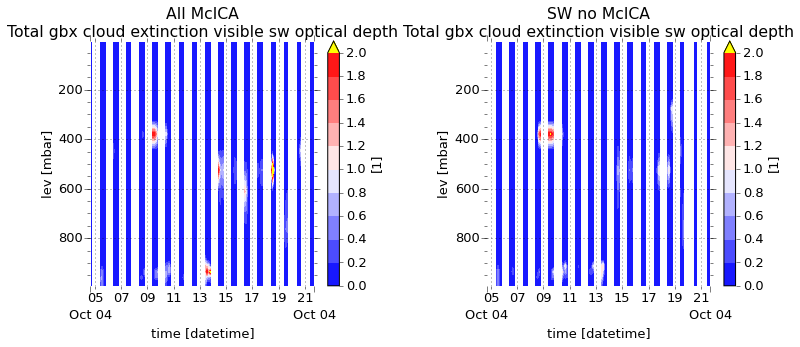

In [65]:
fig = climaviz.contourf_interest_for_all_cases(d3sets, interest = 'TOT_CLD_VISTAU', cmap = plt.cm.get_cmap('bwr'))

In [66]:
# plot and write figures to disk
interests = get_d3interests()

writefig_contourfs(d3sets, diff_d3sets, 
                   interests, sitename = iopname,
                  fmt = 'png')

writefig_timeaveraged_VSplots(d3sets, diff_d3sets,
                              interests, iopname,
                              fmt = 'png')
# generate HTML page for each interest
for interest in get_d3interests():
    write_d3variable_html_page(iopname = iopname, interest = interest)


dfmax 49.0669 dfmin -72.3942 cmap_limit -71.612939859
('both', 71.612939859008875)
dfmax 73.3028 dfmin -65.0083 cmap_limit 59.2613250427
('both', 59.261325042708933)
dfmax 0.344193 dfmin -7.89475 cmap_limit -7.04480714483
('both', 7.0448071448327045)
dfmax 72870.5 dfmin -1.11829e+07 cmap_limit -8920577.4846
('both', 8920577.4846002497)
dfmax 58887.9 dfmin -55570.6 cmap_limit 56637.7797961
('both', 56637.779796092364)
dfmax 16.2987 dfmin -12.4332 cmap_limit 13.3836579475
('both', 13.383657947535569)
dfmax 2.9808 dfmin -49.4421 cmap_limit -46.0261774101
('both', 46.02617741012611)
dfmax 0.844075 dfmin -0.9989 cmap_limit -0.982451946354
('both', 0.98245194635391409)
dfmax 4.01438e-08 dfmin -5.52838e-08 cmap_limit -5.39978597658e-08
('both', 5.3997859765786556e-08)
dfmax 3.31674e-08 dfmin -6.14683e-08 cmap_limit -6.05010407373e-08
('both', 6.0501040737293112e-08)
dfmax 3.53839e-08 dfmin -3.27195e-08 cmap_limit 3.44924716103e-08
('both', 3.4492471610292099e-08)
dfmax 19.5947 dfmin -9.87803 

In [50]:
############### Variables of dimensions (lon, lat, time) ##########################
###################################################################################

In [24]:
def get_d2interests():
    interests = ['FSNT', 'FSNS', 'FLNT', 'FLNS', 'CLDLOW', 'CLDMED', 'CLDHGH', 'CLDTOT',
                'TS', 'TREFHT', 'TROP_T', 'TROP_Z', 'TMQ', 'TGCLDIWP', 'TGCLDLWP', 'PRECT', 'PRECL', 'PRECC',
                'LHFLX', 'SHFLX']
    return interests

In [25]:
def prep_data():

    interests = get_d2interests()

    datasets = {}
    
    for casename, casepath in cases.items():
        with xray.open_dataset(casepath, decode_times = False) as ds:
            datasets[casename] = ds[interests].copy(deep = True)
            datasets[casename].attrs['case_name'] = casename
        
    for casename, ds in datasets.items():
        ds.coords['time'] = ('time', datetimes, {'units': 'datetime',
                                                'long_name': 'time'})
        
        for k in ['PRECC', 'PRECL', 'PRECT']:
            if k in ds:
                ds[k] *= 1e3 * 86400
                ds[k].attrs['units'] = 'mm/day'
        
    return datasets

d2sets = prep_data()

In [26]:
#### Compute difference between all cases for all interested variables
def prep_differences(datasets):
    diff_strs = get_cases_difference()

    return {x + ' - ' + y: datasets[x] - datasets[y] 
            for x, y in diff_strs}    

diff_d2sets = prep_differences(d2sets)

In [27]:
#### Change/correct some of the attributes
## Some of this is needed for labelling plots easily

def prep_attributes(datasets, diff_datasets):
    
    interests = get_d2interests()
    
    for ds_name, ds in diff_datasets.items():
        ds.attrs['case_name'] = ds_name
        for interest in interests:
            ds[interest].attrs = dict(
                datasets[random.choice(list(datasets.keys()))][interest].attrs)
            ds[interest].attrs['case_name'] = ds_name
        
    for ds_name, ds in datasets.items():
        for interest in interests:
            ds[interest].attrs['case_name'] = ds_name
            
    return datasets, diff_datasets

d2sets, diff_d2sets = prep_attributes(d2sets, diff_d2sets)

In [28]:
# for writing figures to disk
def get_line_props():
    return {'All McICA': {'colour': 'g', 'linestyle': '--'},
           'SW no McICA': {'colour': 'g', 'linestyle': '-'}}   

def writefig_plotVS_timeseries(dsets, diff_dsets, interests,
                              sitename, fmt = 'png'):
    for interest in interests:
        fig = climaviz.plotVS_interest_for_all_cases(dsets, diff_dsets, interest = interest,
                                                    linestyles = linestyles_by_case())
        
        dirname = 'figs_{}'.format(sitename)
        if dirname not in glob.glob(dirname):
            os.mkdir(dirname)
            
        fig.savefig(dirname + '/plotVSts_{}.'.format(interest) + fmt)
        plt.close()

def write_d2variable_html_page(iopname = 'mpace', interest = 'FLNS'):
    figdir = 'figs_{iopname}'.format(iopname = iopname)
    with open(os.path.join(figdir, '{iopname}_{interest}.html'\
                           .format(iopname = iopname,
                                   interest = interest)),
             mode = 'w', encoding = 'utf-8') as f:
        f.write('''
        <img src="plotVSts_{interest}.png" width=700>
        '''.format(interest = interest))
        
def write_d2variables_html(iopname = 'mpace', interests = ['FLNS']):
    hyperlinks = ['<a href="figs_{iopname}/{iopname}_{interest}.html">{interest}: {longname}</a>'\
                 .format(iopname = iopname, interest = interest,
                        longname = d2sets[random.choice(list(d2sets.keys()))]\
                         [interest].attrs['long_name'])\
                 for interest in interests]
    return '<br>'.join(hyperlinks)


In [29]:
# plot and write figures to disk
line_props = get_line_props()

writefig_plotVS_timeseries(d2sets, diff_d2sets, get_d2interests(),
                          iopname, fmt = 'png')  

# generate HTML page for each interest
for interest in get_d2interests():
    write_d2variable_html_page(iopname = iopname, interest = interest)


# Variables of dimensions (time, ilev, lon, lat)

In [53]:
display.HTML(write_d3variable_links_html(iopname = iopname, interests = get_d3interests()))

# Variables of dimensions (lon, lat, time)

In [31]:
display.HTML(write_d2variables_html(iopname = iopname, interests = get_d2interests()))

In [32]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [33]:
'TOT_CLD_VISTAU' in d3sets['All McICA']

False